## Model-based Sonification - Tutorial: Example: Particle Trajectory Sonification Model

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
def linlin(x, smi, sma, dmi, dma): return (x-smi)/(sma-smi)*(dma-dmi)+dmi

In [2]:
from pyo import *
import time
s = Server(sr=44100, nchnls=2, buffersize=1024, duplex=0).boot()
s.start()


WxPython is not found for the current python version.
Pyo will use a minimal GUI toolkit written with Tkinter.
This toolkit has limited functionnalities and is no more
maintained or updated. If you want to use all of pyo's
GUI features, you should install WxPython, available here:
http://www.wxpython.org/



In [20]:
# functio to play a vector a single time - interestingly this takes 8.8x too long (!)
def playvec(data, sr=44100.0, rate=1.0, amp=0.5):
    # Create a new table for recording. 
    t = NewTable(length=len(data)/sr, chnls=1)
    t.replace(list(data))
    print t.getLength()
    # Directly use the data as the waveform table. 
    # Just play back the table as rate 
    c = Osc(table=t, freq=[rate, rate], mul=amp).out()
    time.sleep(t.getLength()/rate*8.8) # any idea where the factor 8.8 comes from???
    c.stop()

In [21]:
# The task is to put this part in C. 

def force_1p(pos, sigma2=1.0):
    return -pos*np.exp(-np.sum(pos*pos)/sigma2)/sigma2

#potential is one point. because mp = m = 1. 
def potential_1p(pos, sigma2=1.0):
    return -np.exp(-0.5*np.sum(pos*pos)/sigma2)

def force_ds(data, pos, sigma2=1.0):
    F = 0 
    for x in data:
        F += force_1p(pos-x, sigma2)
    return F

def potential_ds(data, pos, sigma2=1.0):
    V = 0
    for x in data:
        V += potential_1p(pos-x, sigma2)
    return V

def motionstep(pos, vel, force, r, m, dt):
    vel = r * vel + dt / m * force
    pos = pos + dt * vel
    return pos, vel

def PTSM(data, sigma=0.25, E=0, m=0.5, dt=0.01, r=0.99, Nsamp=1000):
    # select random start condition with energy E
    N, dim = np.shape(data)    
    i = np.random.randint(N)
    # initial position
    pos = data[i,:]
    #given a random velocity
    vel = np.random.rand(dim); vel /= np.linalg.norm(vel)/2
    sigma2 = sigma**2
    # V is the potential
    V = potential_ds(data, pos, sigma2)
    # Initialize the trajectory information
    trj = np.zeros((Nsamp, dim+1))
    for i in range(Nsamp):
        force = force_ds(data, pos, sigma2)
        pos, vel = motionstep(pos, vel, force, r, m, dt)
        trj[i] = np.hstack((np.sum(vel), pos)) #Why would hstack work
    return trj

In [41]:
def plotpot(data, sigma=1.0, Nx=40, Ny=40):
    """Potential plot"""
    sigma2= sigma**2
    potmap = np.zeros((Nx, Ny))
    for i in range(Nx):
        for j in range(Ny):
            x = i/Nx-0.5
            y = j/Ny-0.5
            potmap[j,i] = potential_ds(data[:,0:2], np.array([x,y]), sigma2)
    plt.matshow(potmap, cmap=cm.gray, extent=(-0.5,0.5,0.5,-0.5))
    plt.plot(data[:,0], data[:,1], ".")
    plt.axis([-0.5, 0.5, -0.5, 0.5])

In [42]:
# Create a 50 x 2 random data. 
data = np.random.rand(50,4)-[0.5, 0.5, 0.5, 0.5]

# Data, sigma, 
trj = PTSM(data, sigma=0.25, dt=0.05, r=0.999, Nsamp=5000)


0.113378681242


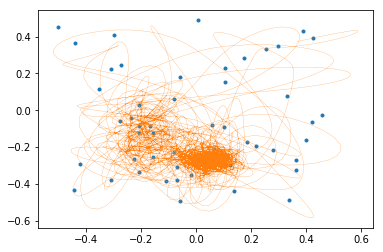

In [43]:
plt.plot(data[:,0], data[:,1], ".")
plt.plot(trj[:,1], trj[:,2], "-", lw=0.2)  # pos (x, y)
playvec(trj[:, 0], rate=1)

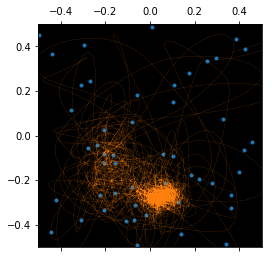

In [49]:
# plot data plus potential function plus trajectory
plotpot(data, 0.15)
plt.plot(trj[:,1], trj[:,2], "-", lw=0.1)

In [50]:
from IPython.html.widgets import *

0.113378681242


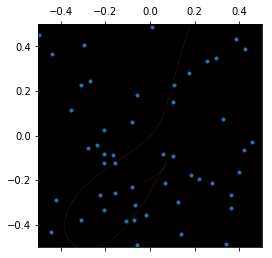

<function __main__.genandplay>

In [52]:
# interaction length, dt, resistence, number of samples
def genandplay(sigma=0.25, dt=0.05, r=0.999, Nsamp=5000):
    global data
    trj = PTSM(data, sigma=sigma, dt=dt, r=r, Nsamp=Nsamp)
    plotpot(data, sigma, 25, 25)
    plt.plot(trj[:,1], trj[:,2], "-", lw=0.1)
    playvec(trj[:, 0], rate=1)
    
interact(genandplay, sigma=(0.1,1,0.01), dt=(0.01,0.1,0.001), r=(0.99, 1, 0.001), Nsamp=(1000, 10000, 100))